# Part 2

In [1]:
# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import numpy as np
import copy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_image, plot_shotrecord

from devito import configuration
configuration['log-level'] = 'WARNING'

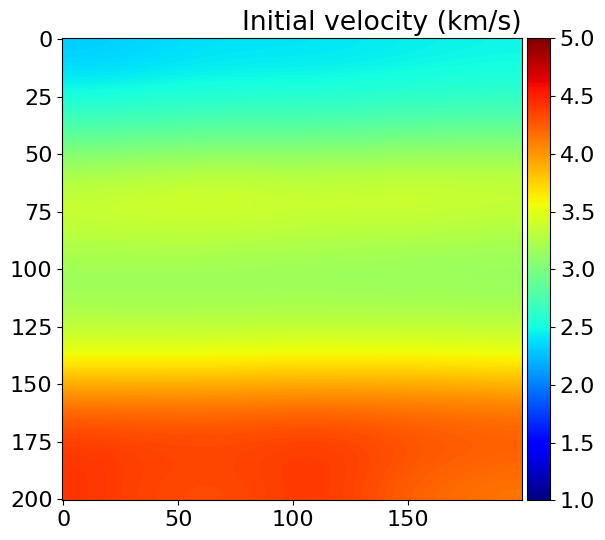

In [2]:
# Important: The values in this cell are defined according to the initial model we have been
# provided and should not be modified!!!!

# Load the initial/smoothed model from file. This smoothed model contains
# the values of vp on a grid defined with the following parameters:

spacing = (10., 10.) # Values in meters
origin = (0., 0.)

v_sm = np.load('data/initial_model.npy', allow_pickle=True)

plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1., vmax=5., cmap="jet")

In [3]:
# Create a Devito model
nbl = 10 # Thickness of the absorbing boundary layer
# model0 nbl=10, itr = 5, space = 10*10
model0 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

In [4]:
# Important: The values in this cell are defined according to our observed data
# and should not be modified!!!!

# The files shot0.npy through to shot10.npy located in data folder contain
# shot records resulting from the configuration defined below:

# Number of sources number = 11, and receivers = 101
nsrc=11; nrcv=101;

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model0.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 2.0 second (4000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)

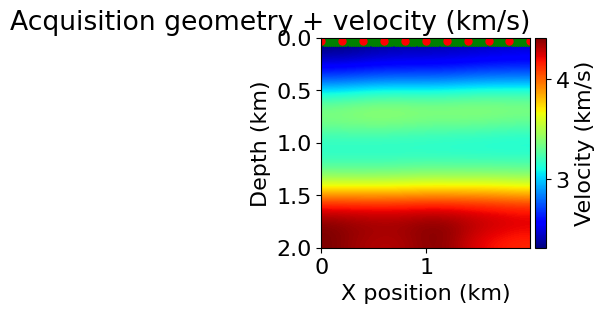

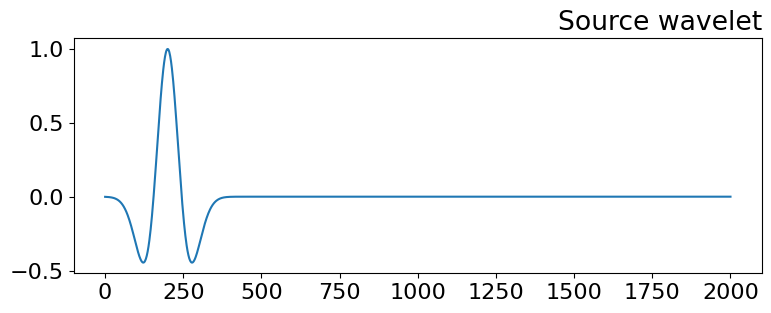

In [5]:
# Create the geometry object and solver object

geometry = AcquisitionGeometry(model0, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model0, geometry, space_order=2)

# Plot acquisition geometry overlaid with initial Vp, and source wavelet
from examples.seismic.plotting import plot_velocity
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.subplot(2,1,1); 
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model0, source=src_loc, receiver=rcv_loc); 

plt.subplot(2,1,2); 
plt.title('Source wavelet', loc='right')
plt.plot(geometry.src.time_values, geometry.src.data[:, 0])
plt.tight_layout(); plt.show()

In [6]:
# Compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

In [7]:
# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='residual', grid=model0.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model0.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])

        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

In [8]:
# Define bounding box constraints (clips) on the solution
# Note: Can modifying vmin, vmax result in a better final image?
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.0, vmax=5.0):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

**1. Simple Line Search Algorith(Armijo condition)**

In [9]:
def armijo_line_search(vp, direction, objective, c=0.01, alpha=1e-3, max_iterations=50):
    vp_backup = copy.deepcopy(vp)
    
    for _ in range(max_iterations):
        
        # Backup the current model
        vp = copy.deepcopy(vp_backup)
        update_with_box(vp, alpha, direction)

        # Compute the new objective function and gradient
        new_objective, _ = fwi_gradient(vp)

        # Armijo condition
        armijo_condition = new_objective <= objective - c * alpha * np.sum(direction.data.flatten() * (direction.data.flatten()))

        if armijo_condition: break

        else: alpha *= 0.5
        # Armijo condition not satisfied, backtrack and reduce the step size
            

    return alpha

In [10]:
# FWI loops, include line search algorithms
fwi_iterations = 5  
objective = np.zeros((fwi_iterations, 1))

for i in range(fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], grad = fwi_gradient(model0.vp)
    
    # Use the Armijo line search algorithm to find the appropriate step size alpha
    alpha = armijo_line_search(model0.vp, grad, objective[i])
    
    # Update the speed model
    update_with_box(model0.vp, alpha, grad)
    
    # Record log
    print(f'Iteration {i+1}: Objective = {objective[i]}, Alpha = {alpha}')

Iteration 1: Objective = [37325113.52476615], Alpha = 1.5625e-05
Iteration 2: Objective = [18801972.09130129], Alpha = 1.5625e-05
Iteration 3: Objective = [12730333.4439247], Alpha = 7.8125e-06
Iteration 4: Objective = [9906024.04858318], Alpha = 1.5625e-05
Iteration 5: Objective = [8634587.42640301], Alpha = 7.8125e-06


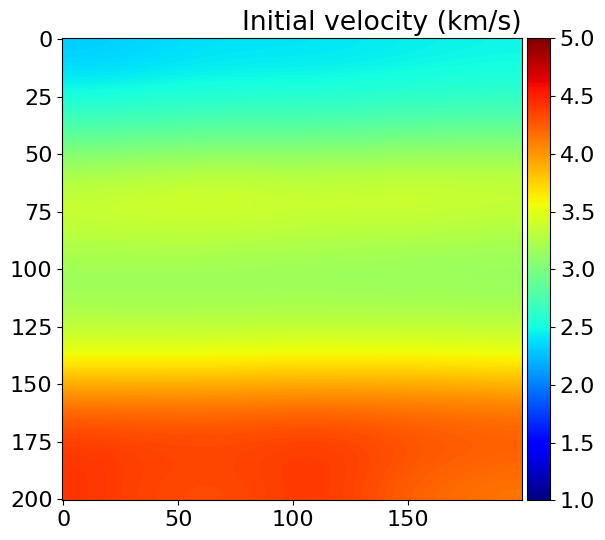

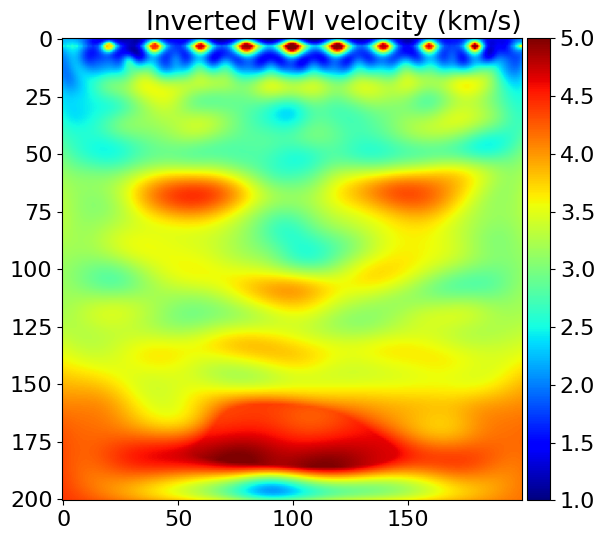

In [11]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.0, vmax=5.0, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

**2. Modify 4 other aspects of the FWI algorithm.**

**What happens when changing the number of FWI iterations.**

Iteration 1: Objective = [23482993.5311028], Alpha = 7.8125e-06
Iteration 2: Objective = [15438301.63547713], Alpha = 3.90625e-06
Iteration 3: Objective = [11423366.76262827], Alpha = 3.90625e-06
Iteration 4: Objective = [10004839.05125397], Alpha = 7.8125e-06
Iteration 5: Objective = [9012234.89897171], Alpha = 3.90625e-06
Iteration 6: Objective = [8317741.72747226], Alpha = 3.90625e-06
Iteration 7: Objective = [7492450.95752437], Alpha = 3.90625e-06
Iteration 8: Objective = [7027300.6860401], Alpha = 3.90625e-06
Iteration 9: Objective = [6580734.60041471], Alpha = 3.90625e-06
Iteration 10: Objective = [6258159.57697716], Alpha = 3.90625e-06
Iteration 11: Objective = [5969045.54891076], Alpha = 3.90625e-06
Iteration 12: Objective = [5738621.94065765], Alpha = 3.90625e-06
Iteration 13: Objective = [5537501.09425367], Alpha = 3.90625e-06
Iteration 14: Objective = [5369157.00952761], Alpha = 7.8125e-06
Iteration 15: Objective = [5270782.85743339], Alpha = 3.90625e-06


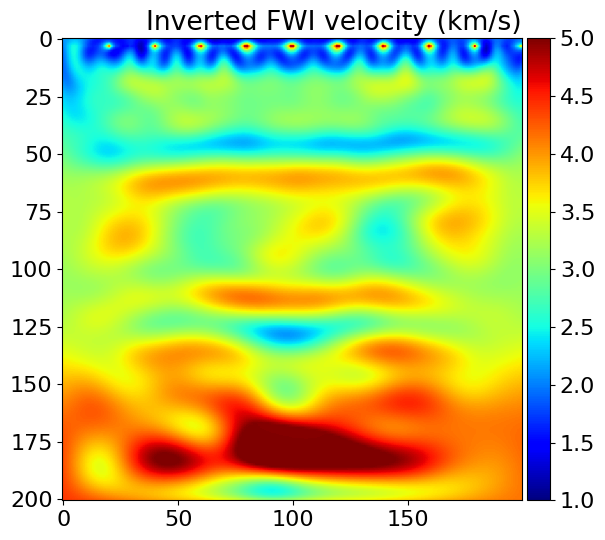

In [12]:
objective = np.zeros((15, 1))

# model1 nbl=10, itr = 15, space = 10*10
model1 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

for i in range(15):
    # Compute the current FWI objective function and gradient
    objective[i], grad = fwi_gradient(model1.vp)
    
    # Use the Armijo line search algorithm to find the appropriate step size alpha
    alpha = armijo_line_search(model1.vp, grad, objective[i])
    
    # Update the speed model
    update_with_box(model1.vp, alpha, grad)
    
    # Record log
    print(f'Iteration {i+1}: Objective = {objective[i]}, Alpha = {alpha}')
    
# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model1.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

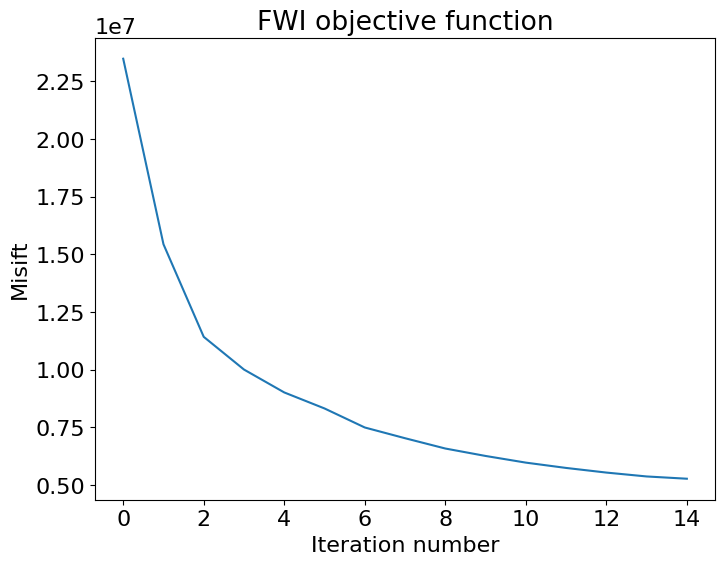

In [13]:
#plot objective function
plt.figure()
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()

- **Changing the number of FWI iterations:** The initial number of iterations was set to 5, and in the final version we chose 15. Increasing the number of iterations usually reduces the misfit to the target value,  potentially leading to a more accurate velocity model. But too many iterations can increase our computational cost significantly. We plotted the relationship between the number of iterations and misfit, and looking at the image we can see that after 15 iterations the value of misfit no longer decreases significantly.

**What happens when modifying the absorbing boundary layer width.**

Iteration 1: Objective = [7585924.52845847], Alpha = 1.5625e-05
Iteration 2: Objective = [11858599.0844427], Alpha = 1.5625e-05
Iteration 3: Objective = [9826935.82736053], Alpha = 7.8125e-06
Iteration 4: Objective = [6562216.84484069], Alpha = 7.8125e-06
Iteration 5: Objective = [5231612.28316638], Alpha = 7.8125e-06
Iteration 6: Objective = [4568405.02926455], Alpha = 7.8125e-06
Iteration 7: Objective = [4220839.11495973], Alpha = 3.90625e-06
Iteration 8: Objective = [3751705.44649704], Alpha = 1.5625e-05
Iteration 9: Objective = [3308351.56500939], Alpha = 3.90625e-06
Iteration 10: Objective = [3159492.75551881], Alpha = 3.90625e-06
Iteration 11: Objective = [3020859.09243908], Alpha = 3.90625e-06
Iteration 12: Objective = [2936691.84708869], Alpha = 3.90625e-06
Iteration 13: Objective = [2861496.17796004], Alpha = 7.8125e-06
Iteration 14: Objective = [2735491.40088205], Alpha = 3.90625e-06
Iteration 15: Objective = [2673126.75663796], Alpha = 3.90625e-06


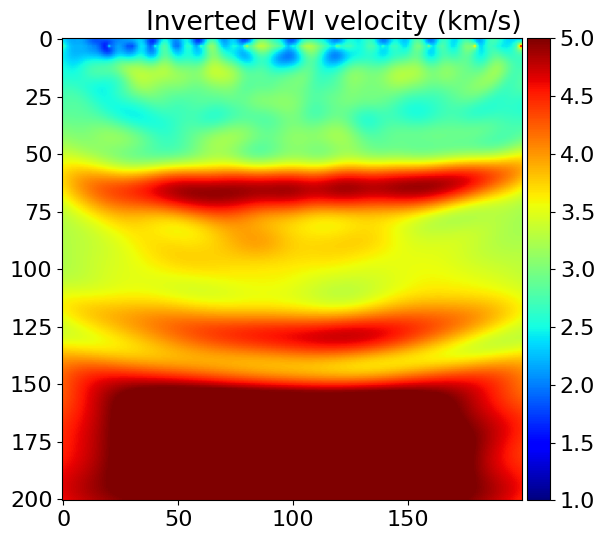

In [14]:
objective = np.zeros((15, 1))

# model2 nbl=80, itr = 15, space = 10*10
nbl = 80
model2 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

# Number of sources number = 11, and receivers = 101
nsrc=11; nrcv=101;

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model2.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model2.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

geometry = AcquisitionGeometry(model2, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model2, geometry, space_order=2)

# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model2.grid)
    residual = Receiver(name='residual', grid=model2.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model2.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model2.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])

        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

for i in range(15):
    # Compute the current FWI objective function and gradient
    objective[i], grad = fwi_gradient(model2.vp)
    
    # Use the Armijo line search algorithm to find the appropriate step size alpha
    alpha = armijo_line_search(model2.vp, grad, objective[i])
    
    # Update the speed model
    update_with_box(model2.vp, alpha, grad)
    
    # Record log
    print(f'Iteration {i+1}: Objective = {objective[i]}, Alpha = {alpha}')
    
# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model2.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

- **Modifying the absorbing boundary layer width:** The absorbing boundary layer is critical in minimizing reflections from the boundaries of the computational domain, which can otherwise contaminate the seismic data with artificial echoes. A thicker boundary layer can provide better absorption of such reflections. Enhancing the ABL width can lead to cleaner wavefields with fewer boundary-related artifacts, improving the quality of the inversion. However, it also increases the computational domain size, thus raising memory requirements and computational time. Ideally, the thickness of the boundary layer should cover at least a few wavelengths to ensure that boundary reflections are effectively absorbed. Using 4 wavelengths as a reference: Boundary layer thickness = 4 × 200m = 800m. Given that the size of each grid is 10mx10m, we need to convert the boundary layer thickness to the number of grid cells. Divide the boundary layer thickness by the size of each grid: nbl = 800m/10m = 80. By looking at the logarithm of the "misfit" output, we can see that the misfit value is greatly reduced after applying 80 boundary layers (initially 10), so we set the number of boundary layers to 80.

**What happens when changing the grid resolution.**

Iteration 1: Objective = [37050282.30961707], Alpha = 3.125e-05
Iteration 2: Objective = [36112032.5002771], Alpha = 6.25e-05
Iteration 3: Objective = [34005778.99102372], Alpha = 3.125e-05
Iteration 4: Objective = [32044593.41307274], Alpha = 3.125e-05
Iteration 5: Objective = [31129862.30246654], Alpha = 3.125e-05
Iteration 6: Objective = [30771855.6294885], Alpha = 1.5625e-05
Iteration 7: Objective = [30346528.60014039], Alpha = 3.125e-05
Iteration 8: Objective = [30073065.11191577], Alpha = 1.5625e-05
Iteration 9: Objective = [29891838.90819022], Alpha = 6.25e-05
Iteration 10: Objective = [29644178.45873889], Alpha = 1.5625e-05
Iteration 11: Objective = [29304020.92722657], Alpha = 1.5625e-05
Iteration 12: Objective = [29102356.35271147], Alpha = 3.125e-05
Iteration 13: Objective = [28843497.91426802], Alpha = 1.5625e-05
Iteration 14: Objective = [28637129.79051828], Alpha = 3.125e-05
Iteration 15: Objective = [28443140.83545578], Alpha = 1.5625e-05


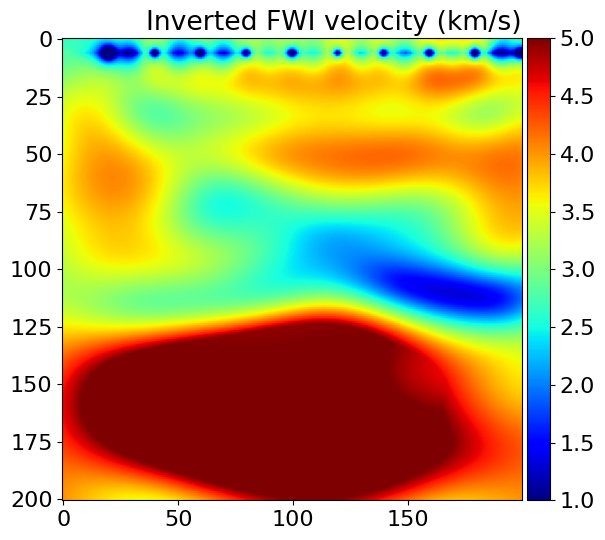

In [15]:
objective = np.zeros((15, 1))
spacing = (5., 5.)

# model3 nbl=80, itr = 15, space = 5*5
model3 = Model(vp=v_sm, space_order=2, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

# Number of sources number = 11, and receivers = 101
nsrc=11; nrcv=101;

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model3.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model3.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

geometry = AcquisitionGeometry(model3, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model3, geometry, space_order=2)

# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model3.grid)
    residual = Receiver(name='residual', grid=model3.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model3.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model3.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])

        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

for i in range(15):
    # Compute the current FWI objective function and gradient
    objective[i], grad = fwi_gradient(model3.vp)
    
    # Use the Armijo line search algorithm to find the appropriate step size alpha
    alpha = armijo_line_search(model3.vp, grad, objective[i])
    
    # Update the speed model
    update_with_box(model3.vp, alpha, grad)
    
    # Record log
    print(f'Iteration {i+1}: Objective = {objective[i]}, Alpha = {alpha}')
    
# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model3.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

**Changing the grid resolution:** 
- Increase the grid resolution by decreasing the spacing from (10m, 10m) to (5m, 5m). The grid resolution determines the smallest details that can be resolved in the velocity model. A higher resolution allows for a more detailed representation of the subsurface features. 
- However, it also exponentially increases the computational load, as more grid points means more computations per iteration and higher memory usage. Also as we try to capture more features, the value of 'misfit' will increase dramatically (and the rate of decline will be faster, but it will also reach near the minimum sooner).
- Without changing the number of iterations, the images we plotted did gain higher resolution and had more detailed information, but lost some of the overall trend. Since there is no real model for comparison, we are not sure if the model in this setting really achieves better performance in real applications.

**What happens when modifying the discretization order of the PDE.**

Iteration 1: Objective = [7585924.52845847], Alpha = 1.5625e-05
Iteration 2: Objective = [11858599.0844427], Alpha = 1.5625e-05
Iteration 3: Objective = [9826935.82736053], Alpha = 7.8125e-06
Iteration 4: Objective = [6562216.84484069], Alpha = 7.8125e-06
Iteration 5: Objective = [5231612.28316638], Alpha = 7.8125e-06
Iteration 6: Objective = [4568405.02926455], Alpha = 7.8125e-06
Iteration 7: Objective = [4220839.11495973], Alpha = 3.90625e-06
Iteration 8: Objective = [3751705.44649704], Alpha = 1.5625e-05
Iteration 9: Objective = [3308351.56500939], Alpha = 3.90625e-06
Iteration 10: Objective = [3159492.75551881], Alpha = 3.90625e-06
Iteration 11: Objective = [3020859.09243908], Alpha = 3.90625e-06
Iteration 12: Objective = [2936691.84708869], Alpha = 3.90625e-06
Iteration 13: Objective = [2861496.17796004], Alpha = 7.8125e-06
Iteration 14: Objective = [2735491.40088205], Alpha = 3.90625e-06
Iteration 15: Objective = [2673126.75663796], Alpha = 3.90625e-06


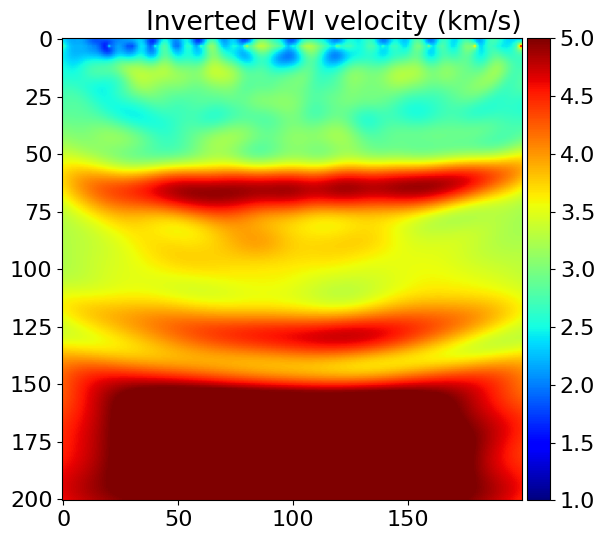

In [16]:
objective = np.zeros((15, 1))
spacing = (10., 10.)

# model4 nbl=80, itr = 15, space = 10*10, solver order = 3
model4 = Model(vp=v_sm, space_order=3, dtype=np.float32, nbl=nbl, grid=None,
               shape=v_sm.shape, origin=origin, spacing=spacing, bcs="damp")

# Number of sources number = 11, and receivers = 101
nsrc=11; nrcv=101;

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model4.domain_size[0], num=nsrc)
src_loc[:, 1] = 30.

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model4.domain_size[0], num=nrcv)
rcv_loc[:, 1] = 30.

geometry = AcquisitionGeometry(model4, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

solver = AcousticWaveSolver(model4, geometry, space_order=3)

# Create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model4.grid)
    residual = Receiver(name='residual', grid=model4.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model4.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model4.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]

        # Load true/observed data from file and interpolate onto our time axis
        file = 'data/shot'+str(i)+'.npy'
        obs_data = np.load(file, allow_pickle=True)
        t_obs_data = np.linspace(t0, tn, num=obs_data.shape[0])
        # Written as a loop for simplicity: Feel free to vectorize this operation
        for j in range(0,nrcv):
            d_obs.data[:, j] = np.interp(geometry.time_axis.time_values, t_obs_data, obs_data[:, j])

        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)

        # Update objective function 
        objective += .5 * norm(residual)**2

        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

for i in range(15):
    # Compute the current FWI objective function and gradient
    objective[i], grad = fwi_gradient(model4.vp)
    
    # Use the Armijo line search algorithm to find the appropriate step size alpha
    alpha = armijo_line_search(model4.vp, grad, objective[i])
    
    # Update the speed model
    update_with_box(model4.vp, alpha, grad)
    
    # Record log
    print(f'Iteration {i+1}: Objective = {objective[i]}, Alpha = {alpha}')
    
# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model4.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.0, vmax=5.0, cmap="jet")

- **Modifying the discretization order of the PDE:** The primary reason for adjusting the discretization order is to balance between the accuracy of the wavefield simulation and the computational resources required. Higher-order schemes can provide more accurate solutions by better approximating the continuous wave equation, capturing more complex wave phenomena such as diffractions and reflections with finer detail. 
- However, this comes at the cost of increased computational complexity and memory requirements, and we can clearly observe that the runtime becomes much longer when running the code.
- We increased the discretization order from 2 to 3, and observing the image we plotted we can see that the image has gained more detail while maintaining the original trend (compared to model2 using a discretization order of 2). There is also a slight improvement in the quality of the image, which indicates that our strategy of increasing the discretization order should be correct.